<a href="https://colab.research.google.com/github/TaqiyNur/sundanese-emotion-classification/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook ini dapat diakses pada [UAS AI-Muhammad Taqiy Nur Furqon]( https://colab.research.google.com/drive/1L56oInGLP05LhoNz05bVXF4AwXcIygoH?usp=sharing)
# Proyek UAS Kecerdasan Buatan
---
## Sundanese Twitter Emotion Classification
Muhammad Taqiy Nur Furqon - 2006468900


## Preparation

In [43]:
!pip install PySastrawi
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import drive
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Proyek UTS AI/')
# Load the Sundanese Twitter dataset
train = pd.read_csv('sundanese_twitter_dataset.csv', sep="\t")
test = pd.read_csv('test_sundanese_twitter_dataset.csv', sep="\t")

Mounted at /content/drive


In [45]:
print("Dataset shape:")
print("Train:", train.shape)
print("Test:", test.shape)


Dataset shape:
Train: (2106, 1)
Test: (412, 1)


In [46]:
train.head(10)

,"label,twt"
0,"anger,""sok geura leungit atuh sia teh corona, ..."
1,"anger,""Nu katoel katuhu nu nyerina kenca, gobl..."
2,"joy,Bingah pisan patepang sareng pangerasa. Si..."
3,"fear,asa hariwang kieu.. lalakon hirup teh asa..."
4,"anger,""Orang mana sih anying, sampis pisan. Bu..."
5,"sadness,nya prihatin siih tp kedah kitu at pak..."
6,"joy,sae nya kang ai tos ningal kompak kitu teh..."
7,"sadness,""Cai soca ngeclak mun emut kana dosa, ..."
8,"anger,""Gokar! Punteun, buat yg masih pd nongkr..."
9,"anger,""kumah pernahnya naik angkot dari Cihamp..."


In [47]:
test.head(10)

,"label,twt"
0,"fear,""meuni asa rame nya crime dimamana... kem..."
1,"joy,""Merinding ningali mic check rrq. Pernah n..."
2,"sadness,""mentang2 mamah ges dulur sabelah, meu..."
3,"fear,meni serem atuh pas buka grup keluarga is..."
4,"sadness,""Meni sedih udah mah ga boleh keluar, ..."
5,"sadness,Meni sedih tapi pami ningal Kopo- Cigo..."
6,"sadness,Meni sedih nempo pimpinan urang"
7,"sadness,Meni sedih laguna bang Bry... Inget ja..."
8,"sadness,""Meni saredih nya, teu paruguh jadina ..."
9,"sadness,""Meni saredih nya, teu paruguh jadina ..."


In [48]:
# Split the combined column into separate columns
train[['label', 'twt']] = train['label,twt'].str.split(',', 1, expand=True)
test[['label', 'twt']] = test['label,twt'].str.split(',', 1, expand=True)

# Remove the combined column
train.drop('label,twt', axis=1, inplace=True)
test.drop('label,twt', axis=1, inplace=True)

<ipython-input-48-63954661ec8a>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  train[['label', 'twt']] = train['label,twt'].str.split(',', 1, expand=True)
<ipython-input-48-63954661ec8a>:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  test[['label', 'twt']] = test['label,twt'].str.split(',', 1, expand=True)


In [49]:
train.head()

,label,twt
0,anger,"""sok geura leungit atuh sia teh corona, matak ..."
1,anger,"""Nu katoel katuhu nu nyerina kenca, goblog was..."
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...
4,anger,"""Orang mana sih anying, sampis pisan. Bunuh ae..."


In [50]:
test.head()

,label,twt
0,fear,"""meuni asa rame nya crime dimamana... kemarin ..."
1,joy,"""Merinding ningali mic check rrq. Pernah ngasa..."
2,sadness,"""mentang2 mamah ges dulur sabelah, meuni te di..."
3,fear,meni serem atuh pas buka grup keluarga isinya ...
4,sadness,"""Meni sedih udah mah ga boleh keluar, di dalem..."


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2106 non-null   object
 1   twt     2106 non-null   object
dtypes: object(2)
memory usage: 33.0+ KB


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   412 non-null    object
 1   twt     412 non-null    object
dtypes: object(2)
memory usage: 6.6+ KB


In [53]:
train.isnull().sum()

label    0
twt      0
dtype: int64

In [54]:
test.isnull().sum()

label    0
twt      0
dtype: int64

In [55]:
# Convert labels to categorical format
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train['label'])
test_labels = label_encoder.fit_transform(test['label'])
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [56]:
# Compile regular expressions
preprocess_regex = re.compile(r'http\S+|www\S+|https\S+|@[^\s]+|[^a-zA-Z\s]')

stopsunda = open('stopwordv1.txt', 'r').read().split()
tokenizer = Tokenizer()

# Create a stemmer instance
stemmer = StemmerFactory().create_stemmer()

# Preprocess and stem the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, special characters, and extra whitespaces
    text = preprocess_regex.sub(' ', text).strip()

    # Remove stopwords and stem the text
    tokens = text.split()
    tokens = [stemmer.stem(token) for token in tokens if token not in stopsunda]

    return ' '.join(tokens)


In [57]:
train['twt'] = train['twt'].apply(preprocess_text)
test['twt'] = test['twt'].apply(preprocess_text)

In [58]:
# Create a tokenizer and fit on the preprocessed text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['twt'])
tokenizer.fit_on_texts(test['twt'])

# Convert the preprocessed text to sequences
sequences_train = tokenizer.texts_to_sequences(train['twt'])
sequences_test = tokenizer.texts_to_sequences(test['twt'])


In [59]:
# Pad sequences to have the same length
max_sequence_length = 200
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)


In [60]:
# Convert the preprocessed text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
features_train = tfidf_vectorizer.fit_transform(train['twt'])
features_test = tfidf_vectorizer.transform(test['twt'])

In [61]:
X_train = features_train
y_train = train_labels

X_test = features_test
y_test = test_labels

X_train.sort_indices()
X_test.sort_indices()

In [62]:
print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (2106, 6501)
Testing X Shape: (412, 6501)


##ANN

In [63]:
ann = Sequential()
ann.add(Dense(64, activation='relu'))
# Adding dropout to prevent overfitting
ann.add(Dropout(0.5))
ann.add(Dense(32, activation='relu'))

ann.add(Dense(len(label_encoder.classes_), activation='sigmoid'))

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
ann.fit(X_train, y_train, epochs=150,validation_data=(X_test,y_test))

Epoch 1/150
66/66 [==============================] - 2s 15ms/step - loss: 0.6269 - accuracy: 0.2583 - val_loss: 0.5446 - val_accuracy: 0.3762
Epoch 2/150
66/66 [==============================] - 1s 12ms/step - loss: 0.5078 - accuracy: 0.6728 - val_loss: 0.4392 - val_accuracy: 0.8859
Epoch 3/150
66/66 [==============================] - 1s 17ms/step - loss: 0.3552 - accuracy: 0.9008 - val_loss: 0.2857 - val_accuracy: 0.9126
Epoch 4/150
66/66 [==============================] - 1s 18ms/step - loss: 0.1922 - accuracy: 0.9729 - val_loss: 0.1799 - val_accuracy: 0.9175
Epoch 5/150
66/66 [==============================] - 1s 18ms/step - loss: 0.0935 - accuracy: 0.9867 - val_loss: 0.1338 - val_accuracy: 0.9272
Epoch 6/150
66/66 [==============================] - 1s 13ms/step - loss: 0.0507 - accuracy: 0.9919 - val_loss: 0.1189 - val_accuracy: 0.9296
Epoch 7/150
66/66 [==============================] - 1s 13ms/step - loss: 0.0320 - accuracy: 0.9967 - val_loss: 0.1115 - val_accuracy: 0.9272
Epoch 

<Axes: >

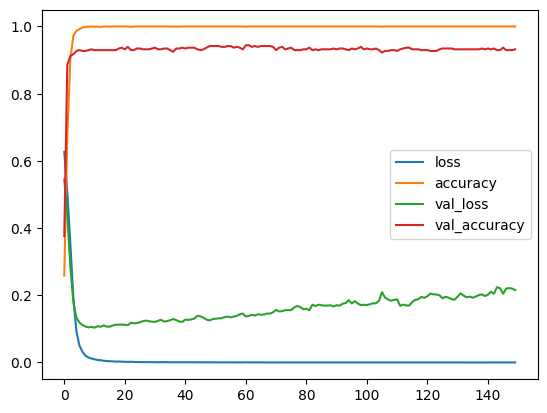

In [65]:
losses = pd.DataFrame(ann.history.history)
losses.plot()

In [66]:
# Evaluate the model
loss, accuracy = ann.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.9320
Test Loss: 0.2157483547925949
Test Accuracy: 0.9320388436317444


13/13 [==============================] - 0s 3ms/step


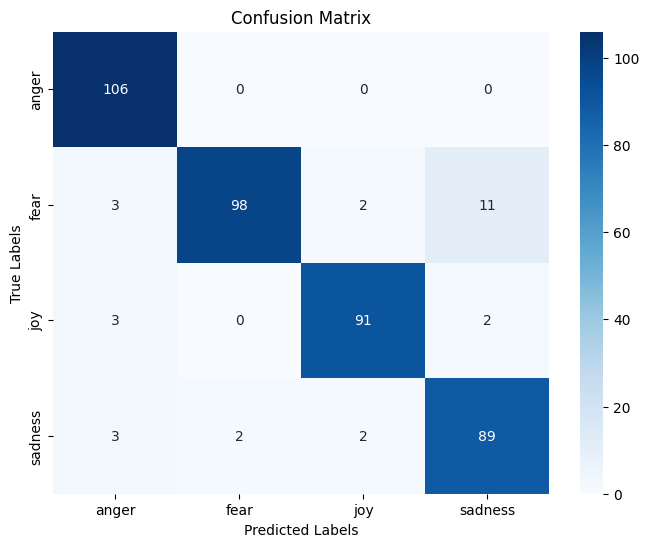

In [67]:
y_pred = ann.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##RNN

In [68]:
# Convert the padded sequences to numpy arrays
X_train = np.array(padded_sequences_train)
X_test = np.array(padded_sequences_test)

# Define the RNN model
embedding_dim = 200
vocab_size = len(tokenizer.word_index) + 1
hidden_units = 64  # Number of hidden units in the RNN layer

rnn = Sequential()
rnn.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
rnn.add(LSTM(hidden_units,dropout=0.5))
rnn.add(Dense(32, activation='relu'))
rnn.add(Dense(16, activation='relu'))
rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [69]:
# Train the model
batch_size = 64
epochs = 100
rnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/100
33/33 [==============================] - 20s 525ms/step - loss: 1.3479 - accuracy: 0.3932 - val_loss: 1.2256 - val_accuracy: 0.4782
Epoch 2/100
33/33 [==============================] - 14s 431ms/step - loss: 0.9795 - accuracy: 0.6040 - val_loss: 0.8107 - val_accuracy: 0.7379
Epoch 3/100
33/33 [==============================] - 14s 426ms/step - loss: 0.4778 - accuracy: 0.8789 - val_loss: 0.4525 - val_accuracy: 0.8568
Epoch 4/100
33/33 [==============================] - 14s 432ms/step - loss: 0.0954 - accuracy: 0.9829 - val_loss: 0.3744 - val_accuracy: 0.8859
Epoch 5/100
33/33 [==============================] - 14s 428ms/step - loss: 0.0288 - accuracy: 0.9953 - val_loss: 0.3610 - val_accuracy: 0.8883
Epoch 6/100
33/33 [==============================] - 14s 433ms/step - loss: 0.0115 - accuracy: 0.9981 - val_loss: 0.3905 - val_accuracy: 0.8811
Epoch 7/100
33/33 [==============================] - 14s 427ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.2802 - val_accuracy:

<Axes: >

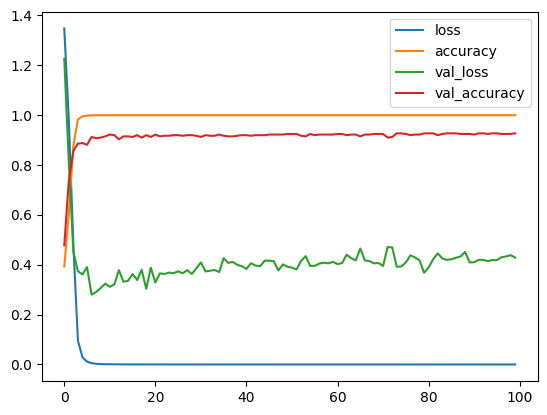

In [70]:
losses = pd.DataFrame(rnn.history.history)
losses.plot()

In [71]:
# Evaluate the model
loss, accuracy = rnn.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 1s 110ms/step - loss: 0.4287 - accuracy: 0.9272
Test Loss: 0.4286973774433136
Test Accuracy: 0.9271844625473022


13/13 [==============================] - 2s 112ms/step


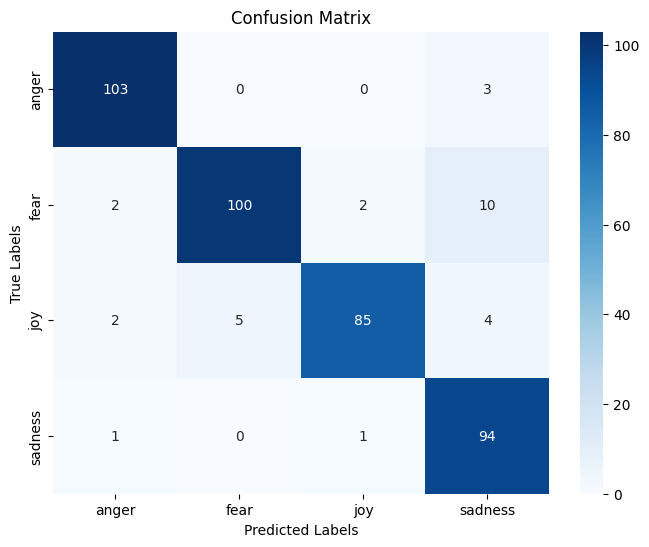

In [72]:
y_pred = rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
